In [5]:
import pandas as pd
import numpy as np

# data description and idea
data = pd.read_csv('data/train.csv')

# transform date to datetime object
from datetime import datetime
times = [datetime.strptime(t, '%d.%m.%Y') for t in data.date]
data.date = times

# data aggregation by day_block
X = pd.DataFrame(data.groupby(['date_block_num','shop_id', 'item_id', 'item_price'])['item_cnt_day'].sum()).reset_index()
X['month'] = X.date_block_num % 12

# create train and eval
np.random.seed(654)
msk = np.random.rand(len(X))< 0.9
X_train = X[msk]
X_eval = X[~msk]

In [49]:
X.iloc[:,[0,1,2,3,4,5]].head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,0,0,32,221.0,6.0,0
1,0,0,33,347.0,3.0,0
2,0,0,35,247.0,1.0,0
3,0,0,43,221.0,1.0,0
4,0,0,51,127.0,1.0,0


In [2]:
# test data preparation
X_test = pd.read_csv('data/test.csv')
X_test['date_block_num'] = 34
X_test['month'] = 11 % 12
X_test.head()

,ID,shop_id,item_id,date_block_num,month
0,0,5,5037,34,11
1,1,5,5320,34,11
2,2,5,5233,34,11
3,3,5,5232,34,11
4,4,5,5268,34,11


In [6]:
# vocabularies for catgories
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
SHOPS_COUNT = len(shops)
ITEMS_COUNT = len(items)
CATS_COUNT = len(item_cats)

   date_block_num  shop_id  item_id  item_price  item_cnt_day  month
0               0        0       32       221.0           6.0      0
1               0        0       33       347.0           3.0      0
2               0        0       35       247.0           1.0      0
3               0        0       43       221.0           1.0      0
4               0        0       51       127.0           1.0      0
    date_block_num  shop_id  item_id  item_price  item_cnt_day  month
11               0        0       98       268.0          25.0      0
12               0        0      111        89.0           1.0      0
19               0        0      306        59.0           1.0      0
27               0        0      556        90.0           9.0      0
44               0        0      965       190.0           1.0      0
shops: 60 item_cat: 84 item_num: 22170 blocks: 34


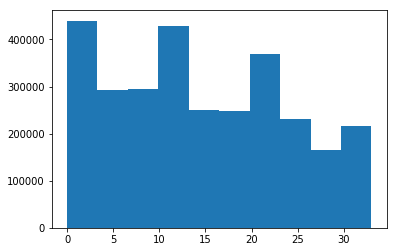

In [4]:
print(X_train.head())
print(X_eval.head())

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# categorical lengths
plt.hist(data.date_block_num)
print('shops:', len(shops), 'item_cat:', len(item_cats), 'item_num:' ,len(items), 'blocks:', len(data.date_block_num.unique()))

In [3]:
import tensorflow as tf

In [1]:
import dnn

d:\coding\python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
# create feature columns
def create_feature_columns():
    item_col = tf.feature_column.categorical_column_with_identity('item_id', num_buckets = ITEMS_COUNT)
    item_col_emb = tf.feature_column.embedding_column(item_col, CATS_COUNT, initializer=tf.ones_initializer)
    month_col = tf.feature_column.categorical_column_with_identity('month', 12)
    month_col_emb = tf.feature_column.embedding_column(month_col, 12, initializer=tf.ones_initializer)
    shop_col = tf.feature_column.categorical_column_with_identity('shop_id', num_buckets = SHOPS_COUNT)
    shop_col_emb = tf.feature_column.embedding_column(shop_col, 60, initializer=tf.ones_initializer)
    
    return [tf.feature_column.numeric_column('date_block_num'), item_col_emb, month_col_emb, shop_col_emb]

# create input function for train and eval
def make_input_fn(df, num_epochs):
    return tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = df['item_cnt_day'],
    batch_size = 64,
    num_epochs = num_epochs,
    shuffle = True
  )

# Feature columns
FEATURES = create_feature_columns()
hidden_units = [48, 16, 16]
learning_rate = 1e-5
OUTPUT_DIR = './trained_model/'+ 'lr' + str(learning_rate) + 'units3' + '_'.join([str(s) for s in hidden_units])
# optimizer
gd = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
# adam = tf.train.AdamOptimizer(learning_rate=0.0001, epsilon=1e-4)
ftrl = tf.train.FtrlOptimizer(0.0001)

# # run_configuration 
run_config = tf.estimator.RunConfig(save_checkpoints_steps = 1000)

# DNN linear estimator
# estimator = tf.estimator.DNNLinearCombinedRegressor(model_dir=OUTPUT_DIR, 
#                                                     dnn_optimizer = gd,
#                                                     linear_optimizer = ftrl,
#                                                     dnn_hidden_units = [32, 16, 1],
#                                                    linear_feature_columns=FEATURES[1:2],
# #                                                     batch_norm = True,
#                                                    dnn_feature_columns = [FEATURES[0], FEATURES[3]],
#                                                     loss_reduction = tf.losses.Reduction.MEAN)
# Lienar Regressor                                                   
# estimator = tf.estimator.LinearRegressor(model_dir=OUTPUT_DIR,
#                                         feature_columns=FEATURES,
#                                         loss_reduction = tf.losses.Reduction.MEAN)

# DNN regressor
estimator = dnn.DNNRegressor(model_dir=OUTPUT_DIR,
                                        optimizer = gd,
                                        hidden_units = hidden_units,
                                        batch_norm = True,
                                        feature_columns=FEATURES,
                                        loss_reduction = tf.losses.Reduction.MEAN, config = run_config)

def train_and_eval(NUM_EPOCHS, estimator):
    
    train_spec = tf.estimator.TrainSpec(input_fn = make_input_fn(X_train, None), max_steps=NUM_EPOCHS)
    eval_spec = tf.estimator.EvalSpec(input_fn = make_input_fn(X_eval, 1), throttle_secs=5)
    
    return tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using config: {'_model_dir': './trained_model/lr1e-05units348_16_16', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002041A6A04E0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
tf.reset_default_graph()
train_and_eval(1000, estimator)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 1000 or save_checkpoints_secs None.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./trained_model/lr1e-05units348_16_16\model.ckpt.
INFO:tensorflow:loss = 8.09375, step = 0
INFO:tensorflow:global_step/sec: 82.4491
INFO:tensorflow:loss = 15.65942, step = 100 (1.215 sec)
INFO:tensorflow:global_step/sec: 130.67
INFO:tensorflow:loss = 7.0733166, step = 200 (0.764 sec)
INFO:tensorflow:global_step/sec: 127.833
INFO:tensorflow:loss = 11.732049, step = 300 (0.783 sec)
INFO:tensorflow:global_step/sec: 127.99

({'average_loss': 49.5603,
  'label/mean': 2.035,
  'loss': 49.5603,
  'prediction/mean': -0.9566368,
  'global_step': 1000},
 [])

In [41]:
result = estimator.predict(input_fn = tf.estimator.inputs.pandas_input_fn(x = X_test,num_epochs=1,shuffle=False))

In [42]:
Y_out = np.array([p['predictions'] for i,p in enumerate(result)]).flatten()

import csv
with open('predictions.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(('ID','item_cnt_month'))
    for i in range(len(Y_out)):
        writer.writerow((i, Y_out[i]))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./trained_model/lr1e-06units48_16_16\model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
